# Datasets and description from https://www.kaggle.com/lucabasa/dutch-energy/


# About this Dataset

Context:

Enexis, Liander, and Stedin are the three major network administrators of the Netherlands and, together, they provide energy to nearly the entire country. Every year, they release on their websites a table with the energy consumption of the areas under their administration.

The data are anonymized by aggregating the Zipcodes so that every entry describes at least 10 connections.

This market is not competitive, meaning that the zones are assigned. This means that every year they roughly provide energy to the same zipcodes. Small changes can happen from year to year either for a change of management or for a different aggregation of zipcodes.
Content

Every file contains information about groups of zipcodes managed by one of the three companies for a specific year.
Acknowledgements

All the data are taken from the following websites:

    https://www.enexis.nl/over-ons/wat-bieden-we/andere-diensten/open-data
    https://www.liander.nl/partners/datadiensten/open-data/data
    https://www.stedin.net/zakelijk/open-data/verbruiksgegevens

Some processing was made with the code available at: https://github.com/lucabasa/kaggle_dutch_energy/blob/master/raw_data_cleaning.ipynb

The translation of the column names and descriptions was made by a non-native speaker.


# Objectives:

1. Determine the smartmeter adoption trend per company.
2. Predict the total electricity consumption in 2020.
3. Determine the trend in home-produced electricity, by company, year, and city.

In [1]:
# import relevant libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
%matplotlib inline

In [5]:
# how are the datasets structured?
elec_enexis_2010 = pd.read_csv('D:\Dropbox\Dropbox\Python\Python Practice\Pandas Projects\Energy_in_Netherlands\Electricity\enexis_electricity_01012010.csv')
print(elec_enexis_2010.shape)
print(elec_enexis_2010.columns)

(107512, 14)
Index(['net_manager', 'purchase_area', 'street', 'zipcode_from', 'zipcode_to',
       'city', 'delivery_perc', 'num_connections',
       'perc_of_active_connections', 'type_conn_perc', 'type_of_connection',
       'annual_consume', 'annual_consume_lowtarif_perc', 'smartmeter_perc'],
      dtype='object')


In [30]:
# create lists of file names per company

filenames_enexis = ['enexis_electricity_01012010.csv', 'enexis_electricity_01012011.csv',
                    'enexis_electricity_01012012.csv', 'enexis_electricity_01012013.csv',
                    'enexis_electricity_01012014.csv', 'enexis_electricity_01012015.csv', 
                    'enexis_electricity_01012016.csv', 'enexis_electricity_01012017.csv', 
                    'enexis_electricity_01012018.csv', 'enexis_electricity_01012019.csv']

filenames_liander = ['liander_electricity_01012009.csv', 'liander_electricity_01012010.csv', 
                     'liander_electricity_01012011.csv', 'liander_electricity_01012012.csv', 
                     'liander_electricity_01012013.csv', 'liander_electricity_01012014.csv', 
                     'liander_electricity_01012015.csv', 'liander_electricity_01012016.csv', 
                     'liander_electricity_01012017.csv', 'liander_electricity_01012018.csv', 
                     'liander_electricity_01012019.csv']

filenames_stedin = ['stedin_electricity_2009.csv', 'stedin_electricity_2010.csv', 
                    'stedin_electricity_2011.csv', 'stedin_electricity_2012.csv', 
                    'stedin_electricity_2013.csv', 'stedin_electricity_2014.csv', 
                    'stedin_electricity_2015.csv', 'stedin_electricity_2016.csv', 
                    'stedin_electricity_2017.csv', 'stedin_electricity_2018.csv', 
                    'stedin_electricity_2019.csv']

# note that file paths will be completed in the rest of this code by where they were located on my PC

Mean smartmeter adoption percentage by company and year is:
      Liander   Stedin    Enexis
Year                            
2009   1.6007  6.80215       NaN
2010  1.67702  7.17521  0.285273
2011  2.00237  7.31445  0.580569
2012   2.8412  7.35654   2.45742
2013  4.01926  7.39271   5.62183
2014  7.33179  10.3737   10.1408
2015  10.7637  14.7373   16.7462
2016   15.675  22.7359   23.7987
2017  26.6404  34.6489   38.0207
2018  38.9945  46.1676   51.3981
2019  54.5102  59.8175   64.1999


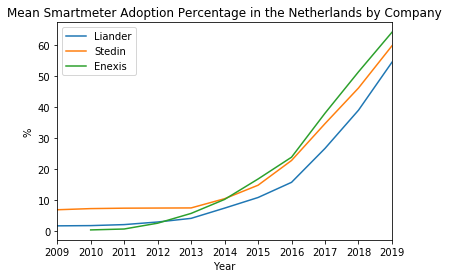

In [31]:
# How are the smart meters spreading?

# also test avoiding importing all files at once into memory

# iterate over all the datasets
for i in range(0, len(filenames_enexis)):
    # note that enexis lacks a 2009 file, need to start with 2010
    # complete the file paths
    file_path_enexis = 'D:\Dropbox\Dropbox\Python\Python Practice\Pandas Projects\Energy_in_Netherlands\Electricity\\' + filenames_enexis[i]
    file_path_liander = 'D:\Dropbox\Dropbox\Python\Python Practice\Pandas Projects\Energy_in_Netherlands\Electricity\\' + filenames_liander[i]
    file_path_stedin = 'D:\Dropbox\Dropbox\Python\Python Practice\Pandas Projects\Energy_in_Netherlands\Electricity\\' + filenames_stedin[i]

    # initialise results dataframes with first year - note this is 2009 for liander and stedin, but 2010 for enexis
    if i == 0:
        # read in data
        data_liander_2009 = pd.read_csv(file_path_liander)
        data_stedin_2009 = pd.read_csv(file_path_stedin)
        data_enexis_2010 = pd.read_csv(file_path_enexis)

        # drop unnecessary columns
        data_liander_total = data_liander_2009.drop(['net_manager', 'purchase_area', 'street', 'city', 
                                                     'num_connections', 'delivery_perc', 
                                                     'perc_of_active_connections', 'type_conn_perc', 
                                                     'type_of_connection', 'annual_consume', 
                                                     'annual_consume_lowtarif_perc'], axis = 1)

        data_stedin_total = data_stedin_2009.drop(['net_manager', 'purchase_area', 'street', 'city', 
                                                   'num_connections', 'delivery_perc', 
                                                   'perc_of_active_connections', 'type_conn_perc', 
                                                   'type_of_connection', 'annual_consume', 
                                                   'annual_consume_lowtarif_perc'], axis = 1)

        data_enexis_total = data_enexis_2010.drop(['net_manager', 'purchase_area', 'street', 'city', 
                                                   'num_connections', 'delivery_perc', 
                                                   'perc_of_active_connections', 'type_conn_perc', 
                                                   'type_of_connection', 'annual_consume', 
                                                   'annual_consume_lowtarif_perc'], axis = 1)

    elif i != len(filenames_enexis)-1: # if not the first year, nor the last for enexis
        data_enexis = pd.read_csv(file_path_enexis)
        data_liander = pd.read_csv(file_path_liander)
        data_stedin = pd.read_csv(file_path_stedin)

        # drop all columns not related to location or smart meter percentage
        data_enexis = data_enexis.drop(['net_manager', 'purchase_area', 'street', 'city', 'num_connections', 
                                        'delivery_perc', 'perc_of_active_connections', 'type_conn_perc', 
                                        'type_of_connection', 'annual_consume', 
                                        'annual_consume_lowtarif_perc'], axis = 1)

        data_liander = data_liander.drop(['net_manager', 'purchase_area', 'street', 'city', 'num_connections', 
                                          'delivery_perc', 'perc_of_active_connections', 'type_conn_perc', 
                                          'type_of_connection', 'annual_consume', 
                                          'annual_consume_lowtarif_perc'], axis = 1)

        data_stedin = data_stedin.drop(['net_manager', 'purchase_area', 'street', 'city', 'num_connections', 
                                        'delivery_perc', 'perc_of_active_connections', 'type_conn_perc', 
                                        'type_of_connection', 'annual_consume', 
                                        'annual_consume_lowtarif_perc'], axis = 1)

        # merge this year's columns with the total dataframes (will change column names at the end)
        # doing inner merges so that it only appends the zipcode ranges that were serviced by each company over the whole time period
        data_liander_total = data_liander_total.merge(data_liander, on = ['zipcode_from', 'zipcode_to'], how = 'inner')
        data_stedin_total = data_stedin_total.merge(data_stedin, on = ['zipcode_from', 'zipcode_to'], how = 'inner')
        data_enexis_total = data_enexis_total.merge(data_enexis, on = ['zipcode_from', 'zipcode_to'], how = 'inner')

    else: # add on 2019 results for enexis, as well as 2018 AND 2019 results for liander and stedin
        # start with 2019 for enexis, and 2018 for liander/stedin, in same way as before
        data_enexis = pd.read_csv(file_path_enexis)
        data_liander = pd.read_csv(file_path_liander)
        data_stedin = pd.read_csv(file_path_stedin)

        data_enexis = data_enexis.drop(['net_manager', 'purchase_area', 'street', 'city', 'num_connections', 
                                        'delivery_perc', 'perc_of_active_connections', 'type_conn_perc', 
                                        'type_of_connection', 'annual_consume', 
                                        'annual_consume_lowtarif_perc'], axis = 1)

        data_liander = data_liander.drop(['net_manager', 'purchase_area', 'street', 'city', 'num_connections', 
                                          'delivery_perc', 'perc_of_active_connections', 'type_conn_perc', 
                                          'type_of_connection', 'annual_consume', 
                                          'annual_consume_lowtarif_perc'], axis = 1)

        data_stedin = data_stedin.drop(['net_manager', 'purchase_area', 'street', 'city', 'num_connections', 
                                        'delivery_perc', 'perc_of_active_connections', 'type_conn_perc', 
                                        'type_of_connection', 'annual_consume', 
                                        'annual_consume_lowtarif_perc'], axis = 1)

        data_enexis_total = data_enexis_total.merge(data_enexis, on = ['zipcode_from', 'zipcode_to'], how = 'inner')
        data_liander_total = data_liander_total.merge(data_liander, on = ['zipcode_from', 'zipcode_to'], how = 'inner')
        data_stedin_total = data_stedin_total.merge(data_stedin, on = ['zipcode_from', 'zipcode_to'], how = 'inner')

        # then add on 2019 for liander and stedin, in same way as before
        file_path_liander_2019 = 'D:\Dropbox\Dropbox\Python\Python Practice\Pandas Projects\Energy_in_Netherlands\Electricity\\' + filenames_liander[-1]
        file_path_stedin_2019 = 'D:\Dropbox\Dropbox\Python\Python Practice\Pandas Projects\Energy_in_Netherlands\Electricity\\' + filenames_stedin[-1]

        data_liander_2019 = pd.read_csv(file_path_liander_2019)
        data_stedin_2019 = pd.read_csv(file_path_stedin_2019)

        data_liander_2019 = data_liander_2019.drop(['net_manager', 'purchase_area', 'street', 'city', 
                                                    'num_connections', 'delivery_perc', 
                                                    'perc_of_active_connections', 'type_conn_perc', 
                                                    'type_of_connection', 'annual_consume', 
                                                    'annual_consume_lowtarif_perc'], axis = 1)

        data_stedin_2019 = data_stedin_2019.drop(['net_manager', 'purchase_area', 'street', 'city', 
                                                  'num_connections', 'delivery_perc', 
                                                  'perc_of_active_connections', 'type_conn_perc', 
                                                  'type_of_connection', 'annual_consume', 
                                                  'annual_consume_lowtarif_perc'], axis = 1)

        data_liander_total = data_liander_total.merge(data_liander_2019, on = ['zipcode_from', 'zipcode_to'], how = 'inner')
        data_stedin_total = data_stedin_total.merge(data_stedin_2019, on = ['zipcode_from', 'zipcode_to'], how = 'inner')

# rename columns to years
columns_e = ['zipcode_from', 'zipcode_to', 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019]
columns_ls = ['zipcode_from', 'zipcode_to', 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019]
data_liander_total.columns = [columns_ls]
data_stedin_total.columns = [columns_ls]
data_enexis_total.columns = [columns_e]

# get means across all years
data_liander_total.loc['mean'] = data_liander_total.mean()
data_liander_means = data_liander_total.iloc[-1].dropna()

data_stedin_total.loc['mean'] = data_stedin_total.mean()
data_stedin_means = data_stedin_total.iloc[-1].dropna()

data_enexis_total.loc['mean'] = data_enexis_total.mean()
data_enexis_means = data_enexis_total.iloc[-1].dropna()

# combine and plot results
data_means = pd.DataFrame({'Liander': data_liander_means, 'Stedin': data_stedin_means, 'Enexis': data_enexis_means})

# need to reset index to convert index to dtype int for plotting properly
data_means = data_means.reset_index()
data_means = data_means.rename(columns={'level_0':'Year'})
data_means = data_means.set_index('Year')

# create list of all years, otherwise only every other year gets shown on plot axis
years = [2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019]

print('Mean smartmeter adoption percentage by company and year is:')
print(data_means)

smartmeter_plot = data_means.plot(kind = 'line', title = 'Mean Smartmeter Adoption Percentage in the Netherlands by Company', xticks = years).set(xlabel = 'Year', ylabel = '%')

Predicted total electricity consumption covered by these three companies in 2020 is 1.46 TWh


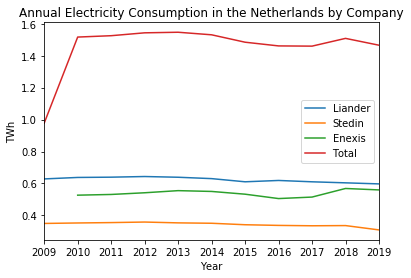

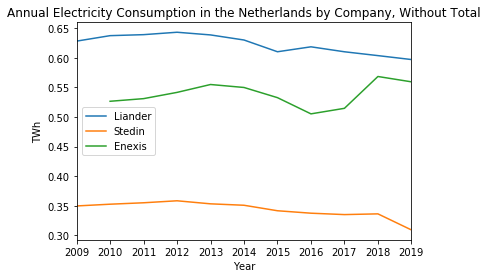

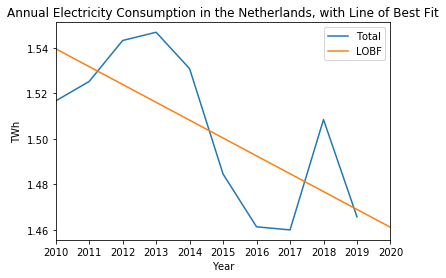

In [32]:
# What is the predicted energy consumption for next year?

# assume this code is run separate to that above

# initialise lists to hold total annual consumptions per company
enexis_cons_list = []
liander_cons_list = []
stedin_cons_list = []

# looping over all the files
for i in range(0, len(filenames_enexis)):
    # complete the file paths
    file_path_enexis = 'D:\Dropbox\Dropbox\Python\Python Practice\Pandas Projects\Energy_in_Netherlands\Electricity\\' + filenames_enexis[i]
    file_path_liander = 'D:\Dropbox\Dropbox\Python\Python Practice\Pandas Projects\Energy_in_Netherlands\Electricity\\' + filenames_liander[i]
    file_path_stedin = 'D:\Dropbox\Dropbox\Python\Python Practice\Pandas Projects\Energy_in_Netherlands\Electricity\\' + filenames_stedin[i]

    # read in the datasets
    enexis_data = pd.read_csv(file_path_enexis)
    liander_data = pd.read_csv(file_path_liander)
    stedin_data = pd.read_csv(file_path_stedin)

    # calculate the total consumption for that year per company
    enexis_cons = enexis_data['annual_consume'].sum()
    liander_cons = liander_data['annual_consume'].sum()
    stedin_cons = stedin_data['annual_consume'].sum()

    # and record it
    enexis_cons_list.append(enexis_cons)
    liander_cons_list.append(liander_cons)
    stedin_cons_list.append(stedin_cons)

    # also calculate 2019 results for liander and stedin (needed because enexis lacks entry for 2009)
    if i == len(filenames_enexis)-1:
        liander_2019_path = 'D:\Dropbox\Dropbox\Python\Python Practice\Pandas Projects\Energy_in_Netherlands\Electricity\\' + filenames_liander[-1]
        stedin_2019_path = 'D:\Dropbox\Dropbox\Python\Python Practice\Pandas Projects\Energy_in_Netherlands\Electricity\\' + filenames_stedin[-1]

        liander_2019_data = pd.read_csv(liander_2019_path)
        stedin_2019_data = pd.read_csv(stedin_2019_path)

        liander_2019_cons = liander_2019_data['annual_consume'].sum()
        stedin_2019_cons = stedin_2019_data['annual_consume'].sum()

        liander_cons_list.append(liander_2019_cons)
        stedin_cons_list.append(stedin_2019_cons)

# create dataframe with annual consumptions for all companies
years = [2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019]
annual_consumptions = pd.DataFrame(liander_cons_list, index = years, columns = ['Liander'])
annual_consumptions['Stedin'] = stedin_cons_list

# reset index to properly make it the year as dtype int
annual_consumptions = annual_consumptions.reset_index()
annual_consumptions = annual_consumptions.rename(columns={'index':'Year'})
annual_consumptions = annual_consumptions.set_index('Year')

# have to create a separate frame and then merge them for enexis, due to the lack of a value for 2009
enexis_dataframe = pd.DataFrame(enexis_cons_list, index = years[1:], columns = ['Enexis'])
enexis_dataframe = enexis_dataframe.reset_index()
enexis_dataframe = enexis_dataframe.rename(columns={'index':'Year'})
enexis_dataframe = enexis_dataframe.set_index('Year')

annual_consumptions = annual_consumptions.merge(enexis_dataframe, on = 'Year', how = 'left')

# from source of stedin data (https://www.stedin.net/zakelijk/open-data/verbruiksgegevens), units for electricity consumption appear to be kWh
# will convert to TWh
annual_consumptions = annual_consumptions.divide(10**9, axis = 'columns')

# calculate total electricity consumption
annual_consumptions['Total'] = annual_consumptions.sum(axis = 1)

# plot data
annual_consumptions.plot(kind = 'line', title = 'Annual Electricity Consumption in the Netherlands by Company', xticks = years).set(xlabel = 'Year', ylabel = 'TWh')

# and plotting just the companies
annual_consumptions[['Liander', 'Stedin', 'Enexis']].plot(kind = 'line', title = 'Annual Electricity Consumption in the Netherlands by Company, Without Total', xticks = years).set(xlabel = 'Year', ylabel = 'TWh')

# so in terms of predicting next years total consumption, can calculate a line of best fit using stats.linregress from scipy
# dropping 2009 in calculations for line of best fit (lobf) as obvious outlier, due to lack of enexis data
total_for_lobf = pd.DataFrame(annual_consumptions['Total'].loc[2010:])
slope, intercept, r_value, p_value, std_err = stats.linregress(total_for_lobf.index, total_for_lobf['Total'])

# calculate values for line of best fit using y = mx + c
lobf = [(x * slope) + intercept for x in years[1:]]
total_for_lobf['LOBF'] = lobf

# extrapolate line to 2020
total_for_lobf.loc[2020] = (2020 * slope) + intercept
total_for_lobf.loc[2020][0] = np.nan

# plot
total_for_lobf.plot(kind = 'line', title = 'Annual Electricity Consumption in the Netherlands, with Line of Best Fit', xticks = (years[1:] + [2020])).set(xlabel = 'Year', ylabel = 'TWh')

# print predicted result for 2020
print('Predicted total electricity consumption covered by these three companies in 2020 is', round(total_for_lobf.loc[2020][1], 2), 'TWh')

The average amount of home-generated electricity in the Netherlands, by year and company is:
              Solar_perc
Year Company            
2009 Liander    0.078533
     Stedin     0.545367
2010 Enexis     0.048385
     Liander    0.139229
     Stedin     0.546750
2011 Enexis     0.090712
     Liander    0.190788
     Stedin     0.545459
2012 Enexis     0.216869
     Liander    0.273852
     Stedin     0.543924
2013 Enexis     1.063436
     Liander    0.682440
     Stedin     0.790703
2014 Enexis     2.241086
     Liander    2.785459
     Stedin     1.479436
2015 Enexis     3.322891
     Liander    3.599407
     Stedin     2.174132
2016 Enexis     5.045606
     Liander    4.660301
     Stedin     2.849279
2017 Enexis     6.517019
     Liander    5.621434
     Stedin     3.470463
2018 Enexis     8.509915
     Liander    6.992472
     Stedin     4.364648
2019 Enexis    11.272396
     Liander    9.460721
     Stedin     6.191254

There are 2479 unique 'cities' in this dataframe, too ma

,Solar_perc
city,
MEERSTAD,57.099444
HOEF EN HAAG,52.341429
LAGELAND,50.113333
STARTENHUIZEN,50.000000
LAGELAND GN,48.483333
REAHUS,44.956667
'T WAAR,43.892000
OOSTERNIELAND,43.460000
BLAUWESTAD,42.384286


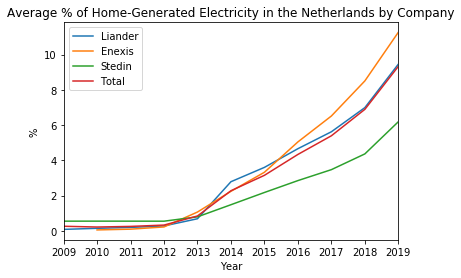

In [27]:
# What is the trend in home-produced energy? (solar panels)

# this time, will aim to make one massive dataframe, and analyse it using pandas groupby() function

# assume this code is run separate to those above

# initialise dataframes for each company
enexis_frame = pd.DataFrame(columns = ['city', 'delivery_perc', 'Year'])
liander_frame = pd.DataFrame(columns = ['city', 'delivery_perc', 'Year'])
stedin_frame = pd.DataFrame(columns = ['city', 'delivery_perc', 'Year'])
years = [2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019]

# loop over all the files
for i in range(0, len(filenames_enexis)):
    # complete the file paths
    file_path_enexis = 'D:\Dropbox\Dropbox\Python\Python Practice\Pandas Projects\Energy_in_Netherlands\Electricity\\' + filenames_enexis[i]
    file_path_liander = 'D:\Dropbox\Dropbox\Python\Python Practice\Pandas Projects\Energy_in_Netherlands\Electricity\\' + filenames_liander[i]
    file_path_stedin = 'D:\Dropbox\Dropbox\Python\Python Practice\Pandas Projects\Energy_in_Netherlands\Electricity\\' + filenames_stedin[i]

    # read files
    enexis_data = pd.read_csv(file_path_enexis)
    liander_data = pd.read_csv(file_path_liander)
    stedin_data = pd.read_csv(file_path_stedin)

    # drop all columns that do not contain city or delivery_perc
    enexis_year_data = pd.DataFrame(enexis_data).drop(['zipcode_from', 'zipcode_to', 'net_manager', 
                                                       'purchase_area', 'street', 'num_connections', 
                                                       'perc_of_active_connections', 'type_conn_perc', 
                                                       'type_of_connection', 'annual_consume', 
                                                       'annual_consume_lowtarif_perc', 'smartmeter_perc'], 
                                                      axis = 1)
    # set year of data
    enexis_year_data['Year'] = years[i+1] # no 2009 data for enexis

    # repeat for liander and stedin
    liander_year_data = pd.DataFrame(liander_data).drop(['zipcode_from', 'zipcode_to', 'net_manager', 
                                                         'purchase_area', 'street', 'num_connections', 
                                                         'perc_of_active_connections', 'type_conn_perc', 
                                                         'type_of_connection', 'annual_consume', 
                                                         'annual_consume_lowtarif_perc', 'smartmeter_perc'], 
                                                        axis = 1)
    liander_year_data['Year'] = years[i]

    stedin_year_data = pd.DataFrame(stedin_data).drop(['zipcode_from', 'zipcode_to', 'net_manager', 
                                                       'purchase_area', 'street', 'num_connections', 
                                                       'perc_of_active_connections', 'type_conn_perc', 
                                                       'type_of_connection', 'annual_consume', 
                                                       'annual_consume_lowtarif_perc', 'smartmeter_perc'], 
                                                      axis = 1)
    stedin_year_data['Year'] = years[i]

    # add results to the overall company frame
    enexis_frame = pd.concat([enexis_frame, enexis_year_data], ignore_index = True)
    liander_frame = pd.concat([liander_frame, liander_year_data], ignore_index = True)
    stedin_frame = pd.concat([stedin_frame, stedin_year_data], ignore_index = True)

    if i == len(filenames_enexis) - 1: # add 2019 for liander/stedin

        file_path_liander = 'D:\Dropbox\Dropbox\Python\Python Practice\Pandas Projects\Energy_in_Netherlands\Electricity\\' + filenames_liander[i+1]
        file_path_stedin = 'D:\Dropbox\Dropbox\Python\Python Practice\Pandas Projects\Energy_in_Netherlands\Electricity\\' + filenames_stedin[i+1]

        liander_data = pd.read_csv(file_path_liander)
        stedin_data = pd.read_csv(file_path_stedin)

        liander_year_data = pd.DataFrame(liander_data).drop(['zipcode_from', 'zipcode_to', 'net_manager', 
                                                             'purchase_area', 'street', 'num_connections', 
                                                             'perc_of_active_connections', 'type_conn_perc', 
                                                             'type_of_connection', 'annual_consume', 
                                                             'annual_consume_lowtarif_perc', 'smartmeter_perc'],
                                                            axis = 1)
        liander_year_data['Year'] = years[i+1]

        stedin_year_data = pd.DataFrame(stedin_data).drop(['zipcode_from', 'zipcode_to', 'net_manager', 
                                                           'purchase_area', 'street', 'num_connections', 
                                                           'perc_of_active_connections', 'type_conn_perc', 
                                                           'type_of_connection', 'annual_consume', 
                                                           'annual_consume_lowtarif_perc', 'smartmeter_perc'], 
                                                          axis = 1)
        stedin_year_data['Year'] = years[i+1]

        liander_frame = pd.concat([liander_frame, liander_year_data], ignore_index = True)
        stedin_frame = pd.concat([stedin_frame, stedin_year_data], ignore_index = True)

# set company names
enexis_frame['Company'] = 'Enexis'
liander_frame['Company'] = 'Liander'
stedin_frame['Company'] = 'Stedin'

# find percent of home produced energy (pesumably solar panel generation)
# (assumed solar because how else would homes generate their own electricity? fossil fuel generators don't seem very likely if they are already connected to the grid)
solar_perc = lambda x: 100 - x

enexis_frame['Solar_perc'] = enexis_frame['delivery_perc'].apply(solar_perc)
liander_frame['Solar_perc'] = liander_frame['delivery_perc'].apply(solar_perc)
stedin_frame['Solar_perc'] = stedin_frame['delivery_perc'].apply(solar_perc)

# concatenate each frame to make one big one
total_frame = pd.concat([enexis_frame, liander_frame, stedin_frame], ignore_index = True)

# show average trend in home-generated power
# group by year and company
grouped_comp = total_frame.groupby(['Year', 'Company'])
print('The average amount of home-generated electricity in the Netherlands, by year and company is:')
print(grouped_comp.mean())

liander = liander_frame.drop(['delivery_perc', 'Company', 'city'], axis = 1).groupby('Year')
enexis = enexis_frame.drop(['delivery_perc', 'Company', 'city'], axis = 1).groupby('Year')
stedin = stedin_frame.drop(['delivery_perc', 'Company', 'city'], axis = 1).groupby('Year')
total = total_frame.drop(['delivery_perc', 'Company', 'city'], axis = 1).groupby('Year')

solar_trend = pd.DataFrame(liander.mean())
solar_trend = solar_trend.rename({'Solar_perc':'Liander'}, axis = 1)
solar_trend['Enexis'] = enexis.mean()
solar_trend['Stedin'] = stedin.mean()
solar_trend['Total'] = total.mean()

solar_trend.plot(kind = 'line', title = 'Average % of Home-Generated Electricity in the Netherlands by Company', xticks = years).set(xlabel = 'Year', ylabel = '%')

# group by year and city
grouped_city = total_frame.groupby(['Year', 'city'])
grouped_city.mean()

# would plot but there are far too many cities for it to be intelligible
print()
print('There are', total_frame.city.nunique(), 'unique \'cities\' in this dataframe, too many to plot.')
# 2479? seems high, guess the electricity companies have a broad definition of a 'city' - probably includes separate towns and villages, perhaps even divides actual cities into multiple

print()
print('The 10 cities with the highest average electricity generation via home-installed solar panels in 2019 are:')
grouped_city.mean().loc[2019].sort_values('Solar_perc', ascending = False).head(10)